# RPN Fine-Tuning for People Detection

In this section, we will fine-tune a Region Proposal Network (RPN) for person detection in images. We will use the Penn-Fudan Pedestrian Detection dataset and PyTorch’s built-in utilities for object detection. By the end, you will have a trained model capable of detecting people in static images and real-time video streams.

![Object Detection](https://h-huang.github.io/tutorials/_static/img/tv_tutorial/tv_image01.png)

## Download and Prepare Dataset and Scripts

1. **Download and Unzip Dataset**  
   - Downloads the PennFudanPed dataset from the official website to the `data` directory.  
   - Unzips the downloaded file in the same directory.

2. **Download Additional Scripts**  
   - Fetches utility scripts (`engine.py`, `utils.py`, `coco_utils.py`, `coco_eval.py`, and `transforms.py`) from the PyTorch Vision GitHub repository.  
   - These scripts provide convenience functions for training and evaluation.


In [1]:
import os

# Create a data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Download and unzip the Penn-Fudan Ped dataset
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

def download_scripts():
    """
    Downloads required PyTorch Vision reference scripts using 'wget'.
    Checks if each file already exists before downloading.
    """
    script_urls = [
        "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py",
        "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py",
        "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py",
        "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py",
        "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"
    ]

    for url in script_urls:
        filename = url.split('/')[-1]
        if not os.path.exists(filename):
            os.system(f"wget {url}")
        else:
            print(f"{filename} already exists, skipping download.")

download_scripts()

## Dataset and Transformations

Here, we define a custom `PennFudanDataset` class to load images and masks from the Penn-Fudan dataset. We also provide a `get_transform` function for data augmentation and preprocessing, as well as a custom `collate_fn` to handle variable-size tensors in batches.

- **`get_transform(train: bool)`**  
  Creates a composed transform that may include random horizontal flips and conversions to tensors.

- **`PennFudanDataset`**  
  - **`__init__`**: Initializes the dataset with the dataset path and optional transforms.  
  - **`__getitem__`**: Loads an image–mask pair, generates bounding boxes from the masks, and prepares the target dictionary.  
  - **`__len__`**: Returns the total number of images in the dataset.

- **`collate_fn`**  
  A custom collate function to handle variable-size tensors within a batch.

In [1]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F

def get_transform(train: bool) -> T.Compose:
    """
    Create a composed transform for the dataset that includes (optionally) random horizontal flip,
    and converts images to floating-point tensors.

    Args:
        train (bool): If True, applies a random horizontal flip with 50% probability.

    Returns:
        T.Compose: A composed transform with flipping and tensor conversion.
    """
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.extend([
        T.ToDtype(torch.float, scale=True),  # Convert image to float and scale pixel values
        T.ToPureTensor()                     # Convert image to pure tensor
    ])
    return T.Compose(transforms)

class PennFudanDataset(Dataset):
    """
    Custom dataset for the Penn-Fudan Pedestrian Detection dataset.
    Each sample includes an image and a corresponding target dictionary.
    """
    def __init__(self, root: str, transforms: T.Compose = None):
        """
        Initialize the dataset with the path to the dataset and an optional set of transforms.

        Args:
            root (str): Path to the root directory of the Penn-Fudan dataset.
            transforms (T.Compose, optional): Optional transform to apply to images and targets.
        """
        self.root = root
        self.transforms = transforms

        # Sort the file names to align images with their corresponding masks
        self.imgs = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))

    def __getitem__(self, idx: int):
        """
        Retrieve an image and its corresponding target dictionary.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            Tuple[tv_tensors.Image, dict]: A tuple containing the image tensor and the target dictionary.
        """
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        # Read the image and mask
        img = read_image(img_path)
        mask = read_image(mask_path)

        # Identify unique object IDs (excluding background = 0)
        obj_ids = torch.unique(mask)[1:]
        num_objs = len(obj_ids)

        # Create binary masks for each object ID
        masks = (mask == obj_ids[:, None, None]).to(torch.uint8)

        # Compute bounding boxes
        boxes = masks_to_boxes(masks)

        # Define labels and other target attributes
        labels = torch.ones(num_objs, dtype=torch.int64)  # Person class = 1
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros(num_objs, dtype=torch.int64)

        # Convert image to a torchvision Image wrapper
        img = tv_tensors.Image(img)

        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
            "masks": tv_tensors.Mask(masks),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms, if provided
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self) -> int:
        """Return the total number of samples in the dataset."""
        return len(self.imgs)

def collate_fn(batch):
    """
    Custom collate function to handle variable-size tensors in a batch.

    Args:
        batch (list): List of (image, target) tuples.

    Returns:
        tuple: A tuple of two lists (images, targets).
    """
    return tuple(zip(*batch))


## Model Fine-Tuning

Below we fine-tune a Faster R-CNN model for person detection:

1. **Load Pre-trained Model**: Initializes a ResNet-50-based Faster R-CNN pre-trained on COCO.  
2. **Adjust Classifier**: Replaces the classifier head to predict only two classes (background and person).  
3. **Switch Backbone**: Demonstrates how to load a pre-trained MobileNetV2 backbone, adjust the output channels, and define custom anchor sizes and aspect ratios.  
4. **Combine Components**: Builds a new Faster R-CNN model using the custom backbone, anchor generator, and RoI pooler.

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 1. Load a pre-trained Faster R-CNN model with a ResNet-50 backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# 2. Adjust the classifier to predict (background + person) = 2 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 3. Replace the backbone with a MobileNetV2 backbone (optional demonstration)
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
backbone.out_channels = 1280

# Define an anchor generator
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# Define an RoI pooler
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],  # Use the first feature map from the backbone
    output_size=7,
    sampling_ratio=2
)

# 4. Combine the custom backbone, anchor generator, and RoI pooler into a Faster R-CNN model
model = FasterRCNN(
    backbone=backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

print("Custom Faster R-CNN model created.")

## Instance Segmentation Model

This section demonstrates how to create a Mask R-CNN model pre-trained on COCO and adjust its heads for a custom number of classes. 

- **`get_model_instance_segmentation(num_classes)`**  
  - Loads a pre-trained Mask R-CNN model.  
  - Replaces the classification and mask heads to accommodate the specified number of classes.
  - Returns the modified Mask R-CNN model.

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes: int):
    """
    Creates an instance segmentation model pre-trained on COCO and modifies it
    to predict a custom number of classes.

    Args:
        num_classes (int): Number of classes for the model (including background).

    Returns:
        model (torchvision.models.detection.MaskRCNN): A Mask R-CNN model with updated heads.
    """
    # Load a Mask R-CNN model pre-trained on the COCO dataset
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Helper function to replace heads
    def replace_head(in_features: int, num_classes: int, predictor_type: str):
        """
        Replace the classification or mask head with a new one for the specified number of classes.
        """
        if predictor_type == "box":
            return FastRCNNPredictor(in_features, num_classes)
        elif predictor_type == "mask":
            hidden_layer = 256
            return MaskRCNNPredictor(in_features, hidden_layer, num_classes)
        else:
            raise ValueError(f"Invalid predictor type: {predictor_type}")

    # Replace the box predictor
    in_features_box = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = replace_head(in_features_box, num_classes, "box")

    # Replace the mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = replace_head(in_features_mask, num_classes, "mask")

    return model

## Training and Evaluation

Here, we train and evaluate our instance segmentation model on the Penn-Fudan dataset:

1. **Device Setup**: Automatically selects GPU if available; otherwise, uses CPU.  
2. **Dataset Preparation**: Creates training and testing splits with appropriate transformations.  
3. **Data Loaders**: Builds PyTorch `DataLoader` objects for training and validation.  
4. **Model Initialization**: Initializes the model (Mask R-CNN in this case) for two classes (background and person).  
5. **Optimizer and Scheduler**: Configures SGD and a step learning rate scheduler.  
6. **Training Loop**: Trains the model for a specified number of epochs, periodically printing progress and evaluating on the test set.

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

# Import utility functions from downloaded scripts
from engine import train_one_epoch, evaluate
from utils import collate_fn  # If 'collate_fn' is in utils, else use the one defined above

# Decide on the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Number of classes: background + person
num_classes = 2

# Create dataset objects
dataset_full = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test_full = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# Split dataset into train/test
indices = torch.randperm(len(dataset_full)).tolist()
train_indices = indices[:-50]
test_indices = indices[-50:]

dataset = Subset(dataset_full, train_indices)
dataset_test = Subset(dataset_test_full, test_indices)

# Create data loaders
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Initialize the model
model = get_model_instance_segmentation(num_classes)
model.to(device)

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Set number of epochs
num_epochs = 2

# Training loop
for epoch in tqdm(range(num_epochs), desc="Epoch"):
    # Train for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Step the scheduler
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("Model training and evaluation complete.")

## Image Processing with RPN Model

In this section, we use our trained RPN-based model to detect pedestrians in a single image:

1. **Load Image**: Reads the image from disk.  
2. **Set Evaluation Mode**: Sets the model to eval mode to disable training layers and dropout.  
3. **Run Inference**: Passes the pre-processed image to the model for prediction.  
4. **Visualization**: Draws bounding boxes and segmentation masks (if available) on the original image for easier interpretation.


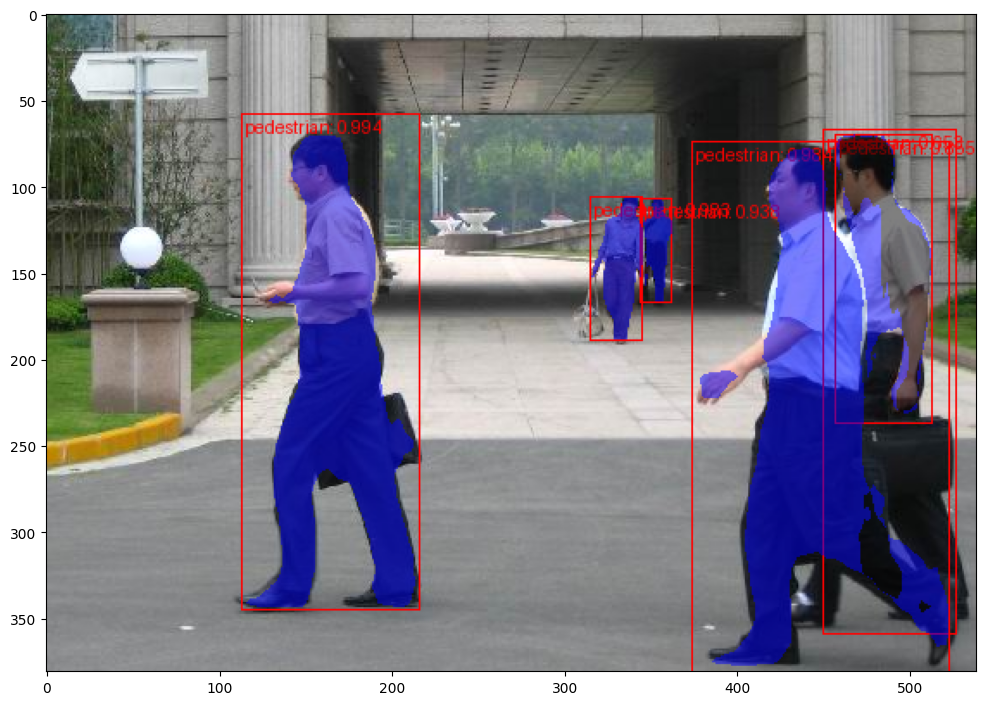

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# Specify the path to an image for testing
image_path = "data/PennFudanPed/PNGImages/FudanPed00007.png"

# Read the image
image = read_image(image_path)

# Create an evaluation transform
eval_transform = get_transform(train=False)

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    # Apply transformations to the image
    x = eval_transform(image)
    # If image has an alpha channel, remove it (taking only RGB)
    x = x[:3, ...].to(device)
    # Get predictions
    predictions = model([x])
    pred = predictions[0]

# Normalize image for visualization
image_normalized = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image_normalized = image_normalized[:3, ...]  # Keep RGB channels

# Prepare labels
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]

# Draw bounding boxes
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image_normalized, pred_boxes, labels=pred_labels, colors="red")

# Draw segmentation masks if available
if "masks" in pred:
    masks = pred["masks"] > 0.7
    output_image = draw_segmentation_masks(output_image, masks.squeeze(1), alpha=0.5, colors="blue")

# Display the output
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis("off")
plt.title("RPN Model Detection")
plt.show()

## Video Processing with RPN Model

Finally, we apply the RPN-based model to a video:

1. **Open Video**: Loads the video file using OpenCV.  
2. **Define Processing Function**: Resizes each frame, runs inference, and draws bounding boxes and masks.  
3. **Save Processed Output**: Writes each processed frame to a new video file.  
4. **Optional Display**: Shows each processed frame in a pop-up window (press `q` to quit).  
5. **Clean Up**: Releases all resources after processing completes.

In [21]:
import cv2
import numpy as np
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_tensor, to_pil_image

def process_frame(frame, model, device, eval_transform):
    """
    Process a single video frame with the RPN model:
      1. Resize for faster inference (optional).
      2. Convert to tensor and apply the evaluation transform.
      3. Run the model in eval mode.
      4. Draw bounding boxes and segmentation masks on the image.

    Args:
        frame (np.ndarray): A single frame from the video in BGR format.
        model (torch.nn.Module): The trained RPN-based PyTorch model.
        device (torch.device): The device (CPU or GPU) for inference.
        eval_transform (callable): The transformation pipeline used for evaluation.

    Returns:
        PIL.Image: The processed frame as a PIL Image with drawn annotations.
    """
    # Resize frame to a smaller resolution (optional)
    resized_frame = cv2.resize(frame, (854, 480))  # Adjust as needed
    
    # Convert frame to tensor and move to device
    image_tensor = to_tensor(resized_frame).to(device)

    # Apply evaluation transforms
    x = eval_transform(image_tensor)

    # Remove alpha channel if present
    x = x[:3, ...].to(device)

    # Run inference
    model.eval()
    with torch.no_grad():
        predictions = model([x])
        pred = predictions[0]

    # Prepare image for drawing
    # Normalize
    image_normalized = (255.0 * (image_tensor - image_tensor.min())
                        / (image_tensor.max() - image_tensor.min())).to(torch.uint8)
    image_normalized = image_normalized[:3, ...]

    # Prepare labels
    pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
    pred_boxes = pred["boxes"].long()

    # Draw bounding boxes
    output_image = draw_bounding_boxes(
        image_normalized,
        pred_boxes,
        labels=pred_labels,
        colors="green",
        width=2,
        font_size=128
    )

    # Draw segmentation masks if available
    if "masks" in pred:
        masks = (pred["masks"] > 0.7).squeeze(1)
        output_image = draw_segmentation_masks(output_image, masks, alpha=0.3, colors="limegreen")

    return to_pil_image(output_image)

# Path to the input video
video_path = 'people_walking.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print(f"Error: Could not open video {video_path}.")
    cap.release()
    raise SystemExit

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)

# Define codec and create VideoWriter
output_path = 'output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (854, 480))

# Define device and transformations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eval_transform = get_transform(train=False)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process the frame
    processed_pil = process_frame(frame, model, device, eval_transform)

    # Convert processed frame to OpenCV-compatible format
    processed_frame = cv2.cvtColor(np.array(processed_pil), cv2.COLOR_RGB2BGR)

    # Write the processed frame to the output video
    out.write(processed_frame)

    # Optional: Display the processed frame
    cv2.imshow('Processed Frame', processed_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up resources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Video processing complete. Output saved to {output_path}")

Video processing complete. Output saved to output_video.mp4
